In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
# from learntools.time_series.ex6 import *

# Setup notebook
from pathlib import Path
import ipywidgets as widgets
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import (create_multistep_example,
                                          load_multistep_data,
                                          make_lags,
                                          make_multistep_target,
                                          plot_multistep)

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor


comp_dir = Path('store-sales-time-series-forecasting')
store_sales = pd.read_csv(
   'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

test = pd.read_csv(
    'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [2]:
print("Training Data", "\n" + "-" * 13 + "\n", store_sales)
print("\n")
print("Test Data", "\n" + "-" * 9 + "\n", test)

Training Data 
-------------
                                      sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]


Test Data 
---------
                                       id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08

In [11]:
# family_sales

In [3]:
# Create multistep dataset for Store Sales
y = family_sales.loc[:, 'sales']

# YOUR CODE HERE: Make 4 lag features
X = make_lags(y, lags=4).dropna()

# YOUR CODE HERE: Make multistep target
y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)


In [5]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y)

display(X)

In [8]:
from sklearn.multioutput import RegressorChain
model = RegressorChain(XGBRegressor())
from sklearn.multioutput import RegressorChain
model = RegressorChain(XGBRegressor())
model.fit(X, y)

y_pred = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
).clip(0.0)

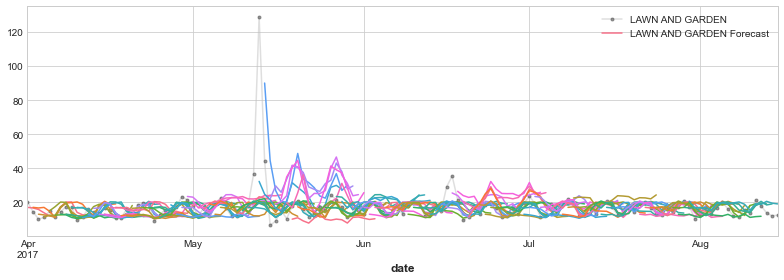

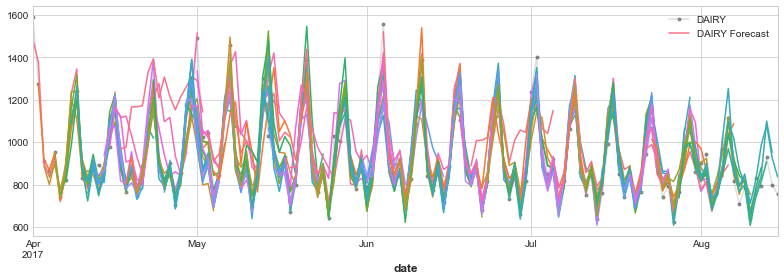

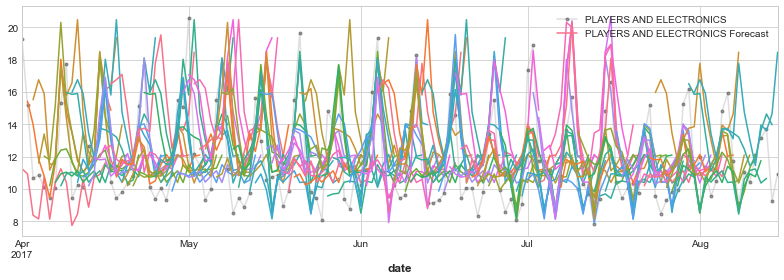

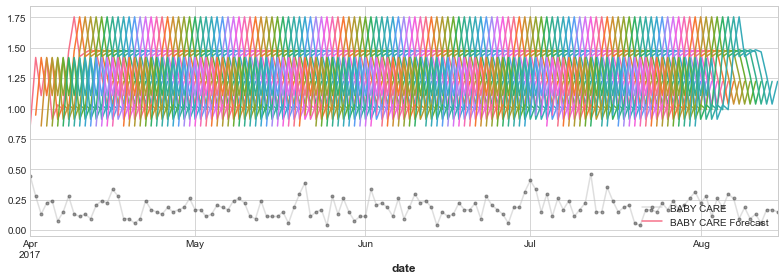

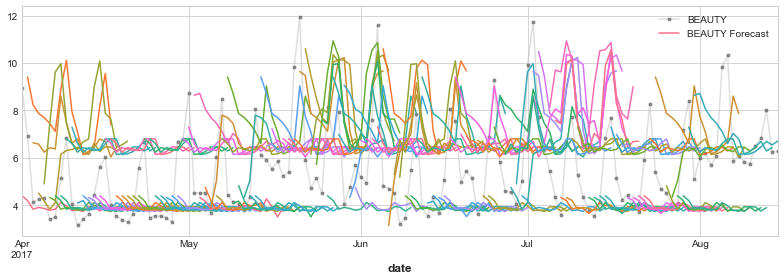

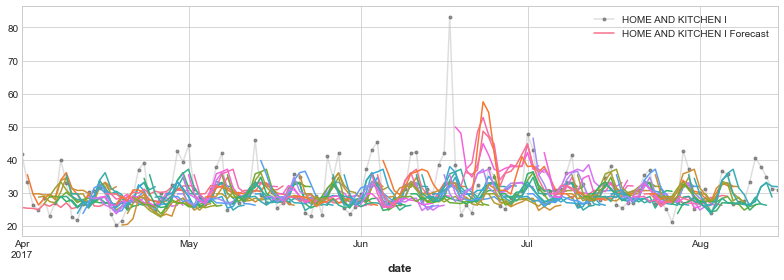

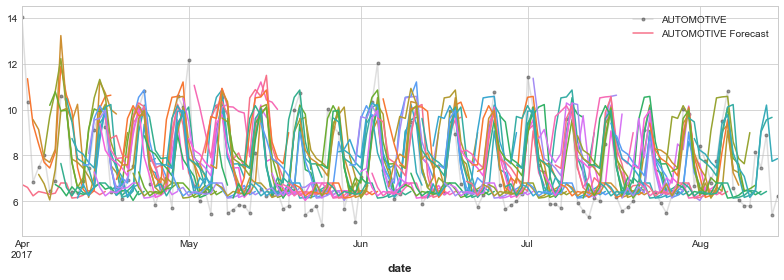

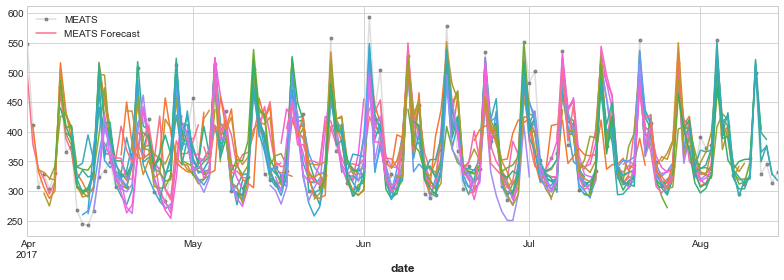

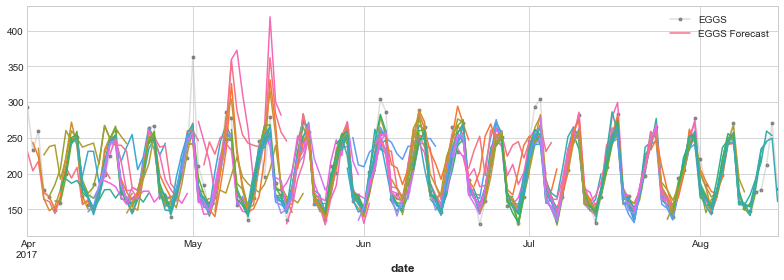

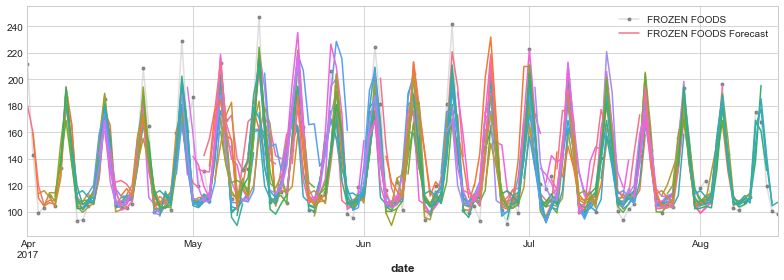

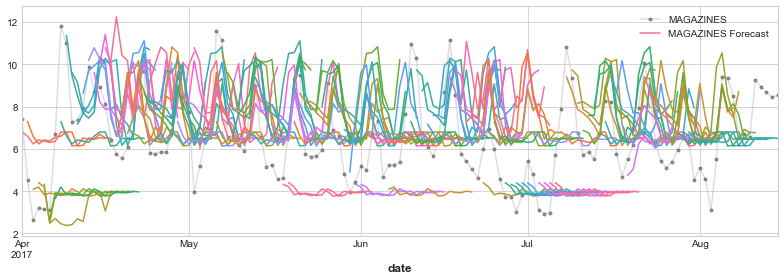

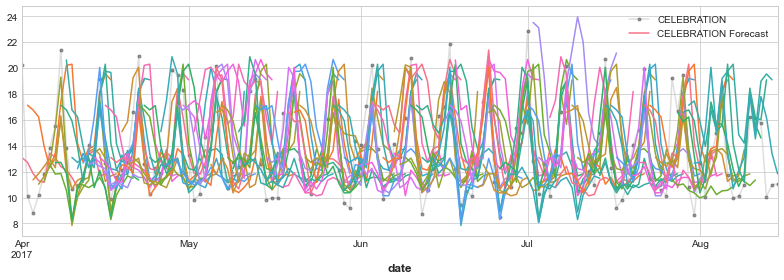

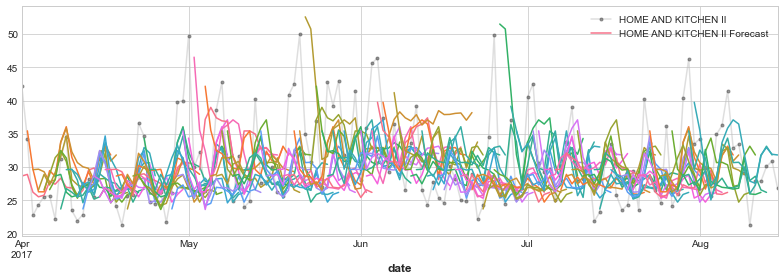

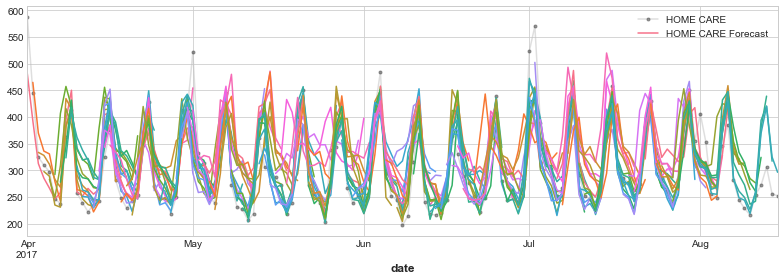

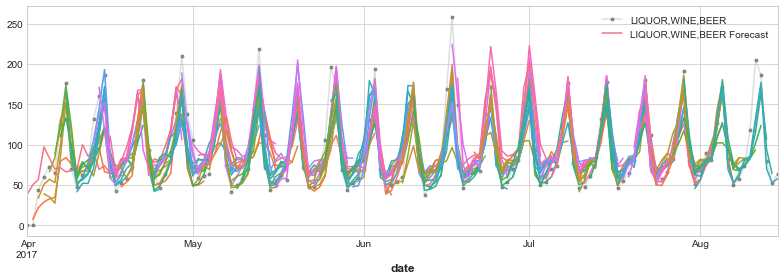

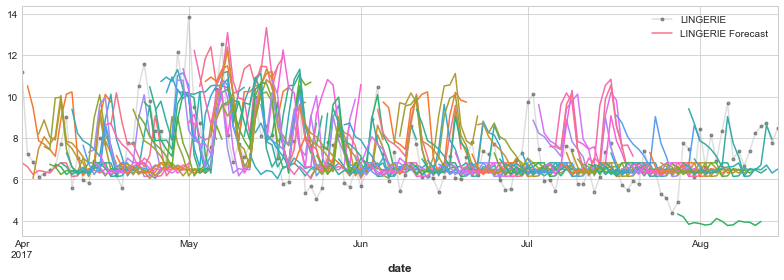

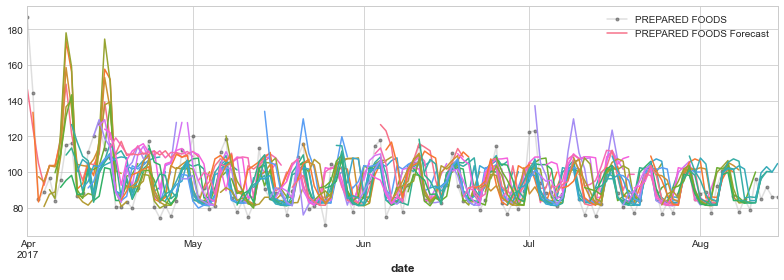

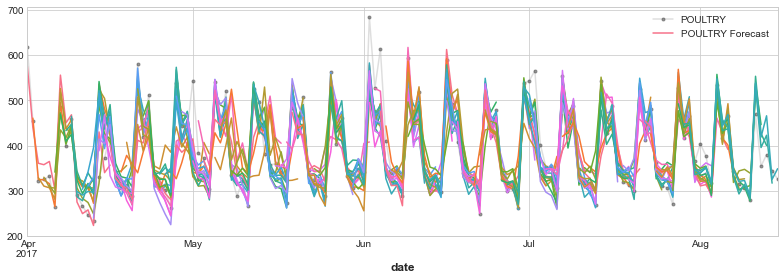

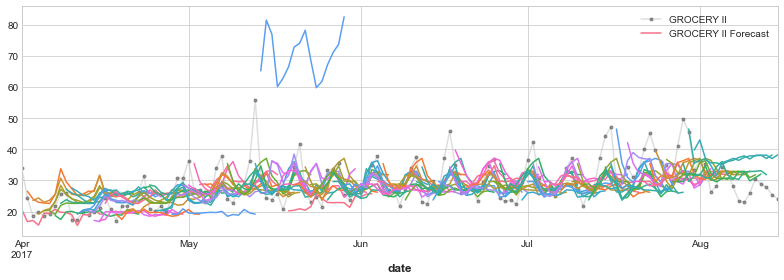

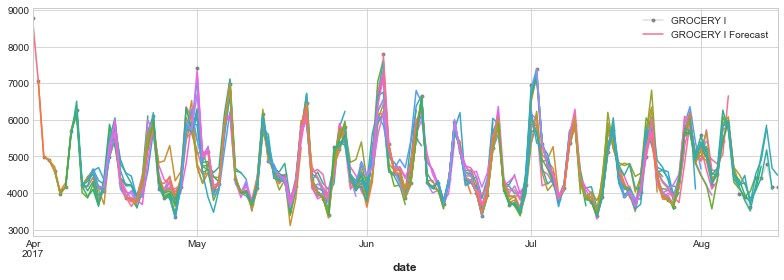

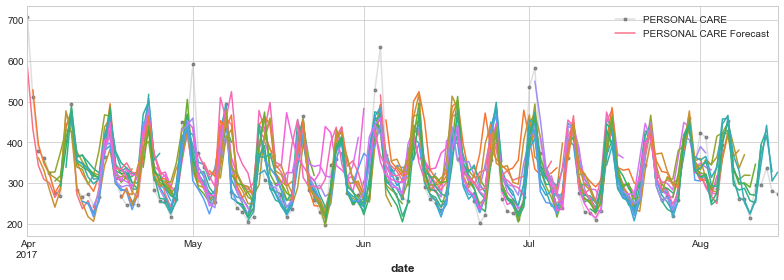

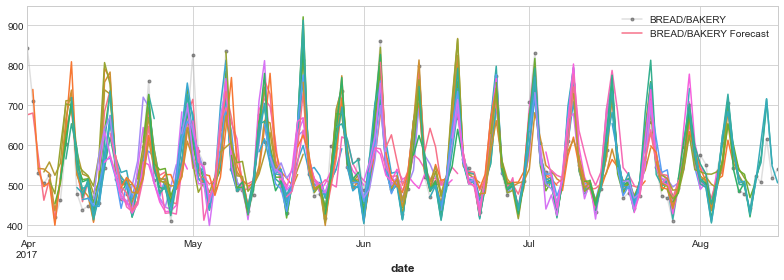

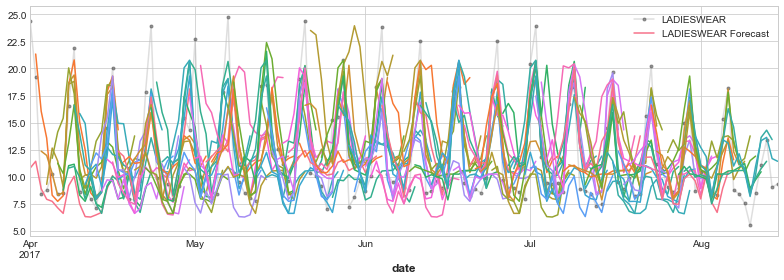

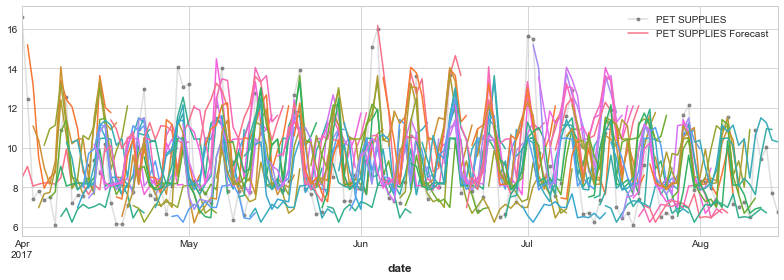

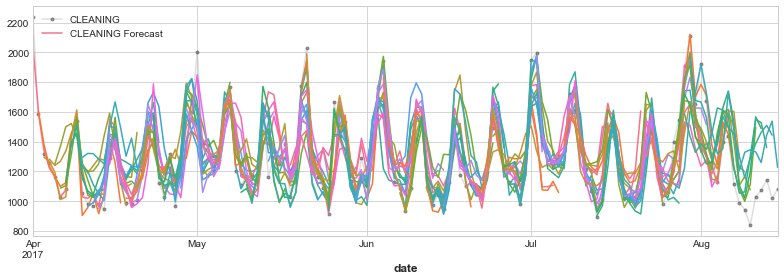

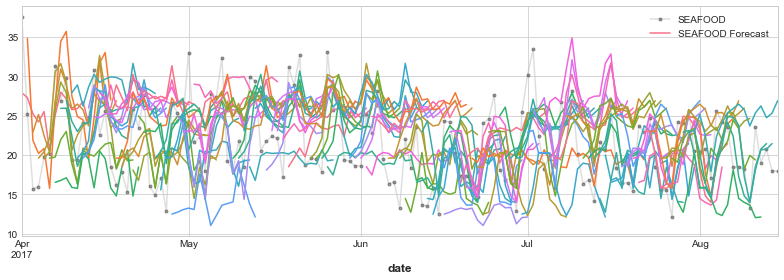

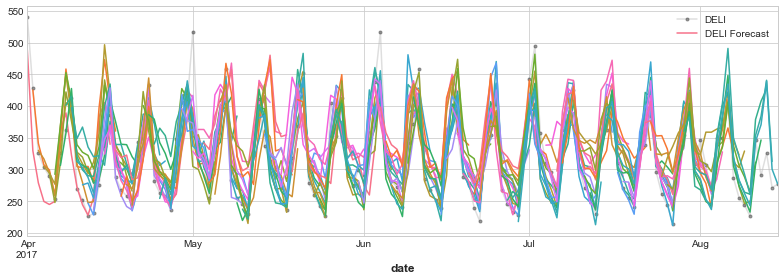

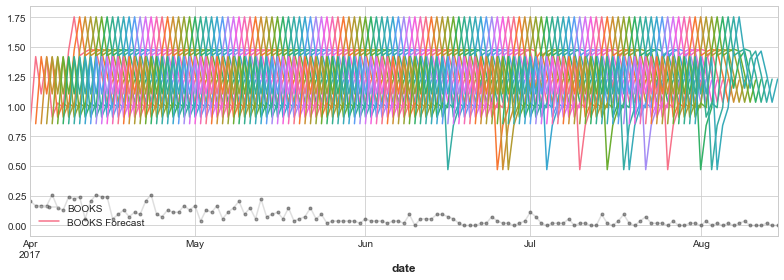

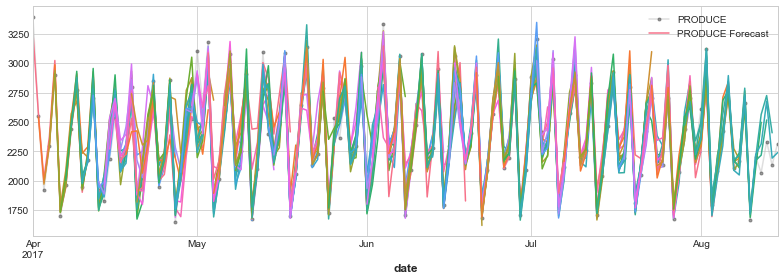

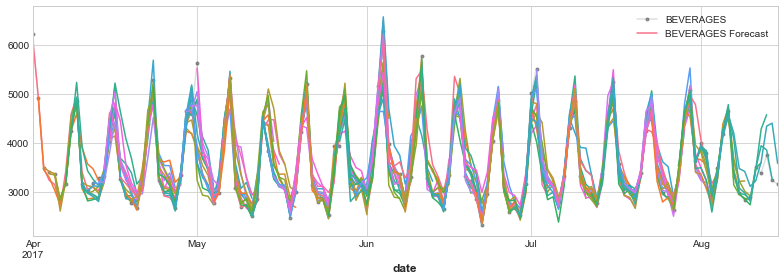

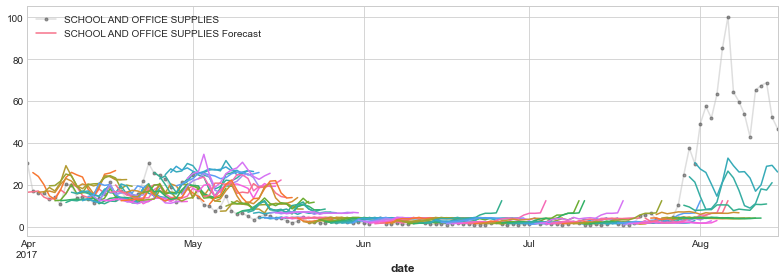

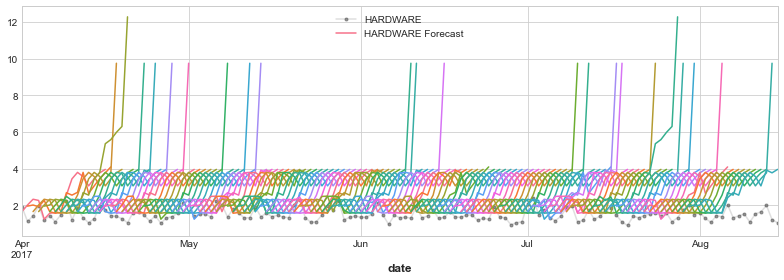

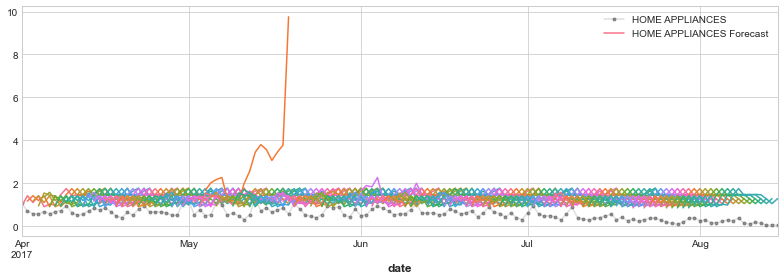

In [9]:
category = set(store_sales.reset_index('family')['family'].tolist())
FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 1
for FAMILY in category:
    y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
    y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

    fig, ax = plt.subplots(1, 1, figsize=(11, 4))
    ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
    ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
    _ = ax.legend([FAMILY, FAMILY + ' Forecast'])

In [ ]:
Corporación Favorita: the competition Store Sales is derived from.
Rossmann Store Sales
Wikipedia Web Traffic
Walmart Store Sales
Walmart Sales in Stormy Weather
M5 Forecasting - Accuracy